In [1]:
from __future__ import print_function, division

# import urllib.request
import requests

from bs4 import BeautifulSoup, SoupStrainer
import pandas as pd
import numpy as np
import unicodedata
import requests
import re

import time
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [131]:
from time import sleep

def fetch_page(base_url, page):
    print('fetching page %s' % (base_url % page))
    
    time.sleep(1)
    return requests.get(base_url % page).text

def get_game_link(html_element):
    BASE_GAME_URL = 'https://boardgamegeek.com/'
    return BASE_GAME_URL + html_element.find_all('a', href=True)[1].get('href')
    
def parse_page(html):
    soup = BeautifulSoup(html, 'lxml')
    
    #Find the table with game descriptions
    games_table_id = soup.find('table', id="collectionitems")
    game_rows = games_table_id.findAll('tr')

    #Get data from rows
    parsed_games = []

    for game_row in game_rows[1:]:
        columns = game_row.find_all('td')
        game_attributes = [column.text.strip() for column in columns]
        
        game_link = get_game_link(game_row)
        game_attributes.append(game_link)
        
        parsed_games.append([attribute for attribute in game_attributes if attribute])
        
    return parsed_games

In [132]:
BASE_URL = 'https://boardgamegeek.com/browse/boardgame/page/%d'

def fetch_game_stats(base_url, pages=1):
    raw_pages = [fetch_page(base_url, page) for page in range(1, pages + 1)]
    parsed_pages = [parse_page(raw_page) for raw_page in raw_pages]
    game_stats = []
    
    for page in parsed_pages:
        game_stats.extend(page)
    return game_stats

game_stats = fetch_game_stats(BASE_URL, 7)

game_attribute_names = ['Rank','Title','GeekRating','AvgRating','NumVotes','Price', 'Link']
game_stats_df = pd.DataFrame(game_stats, columns=game_attribute_names)

fetching page https://boardgamegeek.com/browse/boardgame/page/1
fetching page https://boardgamegeek.com/browse/boardgame/page/2
fetching page https://boardgamegeek.com/browse/boardgame/page/3
fetching page https://boardgamegeek.com/browse/boardgame/page/4
fetching page https://boardgamegeek.com/browse/boardgame/page/5
fetching page https://boardgamegeek.com/browse/boardgame/page/6
fetching page https://boardgamegeek.com/browse/boardgame/page/7


In [136]:
game_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
Rank          700 non-null object
Title         700 non-null object
GeekRating    700 non-null object
AvgRating     700 non-null object
NumVotes      700 non-null object
Price         700 non-null object
Link          700 non-null object
dtypes: object(7)
memory usage: 38.4+ KB


In [147]:
game_links = game_stats_df['Link'].tolist()

loaded_pages = []

In [168]:
#Clean up the DF a little (drop price and the first emptry row)
game_stats_df = game_stats_df.drop('Price', axis=1)

,Rank,Title,GeekRating,AvgRating,NumVotes,Link
0,1,Gloomhaven\n(2017),8.613,9.00,14478,https://boardgamegeek.com//boardgame/174430/gl...
1,2,Pandemic Legacy: Season 1\n(2015),8.501,8.66,25498,https://boardgamegeek.com//boardgame/161936/pa...
2,3,Through the Ages: A New Story of Civilization\...,8.310,8.62,11914,https://boardgamegeek.com//boardgame/182028/th...
3,4,Twilight Struggle\n(2005),8.201,8.34,30914,https://boardgamegeek.com//boardgame/12333/twi...
4,5,Terraforming Mars\n(2016),8.194,8.38,24645,https://boardgamegeek.com//boardgame/167791/te...


In [4]:
#Getting the links for all the games on the page with Selenium 

# div = driver.find_elements_by_class_name('collection_objectname')
# game_links = [i.find_element_by_css_selector('a').get_attribute('href') for i in div]
# print(type(game_links))

<class 'list'>


In [145]:
#Function to pull the parameters I am interested in from a game page
#s = '"yearpublished":"1999","minplayers":"2","maxplayers":"2","minplaytime":"480","maxplaytime":"480", userplayers":{"best":ff"min":3'

def param_search(text):
    keys = ['yearpublished', 'minplayers', 'maxplayers','minplaytime','maxplaytime']
    output_dict = {}
    for key in keys:
        match = re.search(f'"{key}":"?(\d+.?\d*)"', text)
        if match:
            result = match.group(1)
        else:
            result = None
#         match = re.search(f'"{key}":"(\d+)"', text)
        output_dict[key] = result
        
    best = re.search('userplayers":{"best":\[{"min":(\d+)', text)
    if best:
        output_dict['best'] = best.group(1)
    output_dict['averageweight'] = re.search('averageweight":(\d+.?\d*)', text).group(1)
    return output_dict

In [156]:
#Create a list of game parameters to store scraped data into
counter = 1

for i in game_links[600:700]:
    print('Fetching page %d' % counter)
    counter += 1
    r = requests.get(i)
    loaded_pages.append(r.text)

    time.sleep(1)

Fetching page 1
Fetching page 2
Fetching page 3
Fetching page 4
Fetching page 5
Fetching page 6
Fetching page 7
Fetching page 8
Fetching page 9
Fetching page 10
Fetching page 11
Fetching page 12
Fetching page 13
Fetching page 14
Fetching page 15
Fetching page 16
Fetching page 17
Fetching page 18
Fetching page 19
Fetching page 20
Fetching page 21
Fetching page 22
Fetching page 23
Fetching page 24
Fetching page 25
Fetching page 26
Fetching page 27
Fetching page 28
Fetching page 29
Fetching page 30
Fetching page 31
Fetching page 32
Fetching page 33
Fetching page 34
Fetching page 35
Fetching page 36
Fetching page 37
Fetching page 38
Fetching page 39
Fetching page 40
Fetching page 41
Fetching page 42
Fetching page 43
Fetching page 44
Fetching page 45
Fetching page 46
Fetching page 47
Fetching page 48
Fetching page 49
Fetching page 50
Fetching page 51
Fetching page 52
Fetching page 53
Fetching page 54
Fetching page 55
Fetching page 56
Fetching page 57
Fetching page 58
Fetching page 59
Fetchi

In [158]:
#Create a list of game parameters to store scraped data into
game_param = []
counter = 1

for page in loaded_pages:
    print('Parsing page %d' % counter)
    counter += 1
    soup = BeautifulSoup(page, 'lxml')
    res = param_search (soup.text)
    game_param.append(res)

Parsing page 1
Parsing page 2
Parsing page 3
Parsing page 4
Parsing page 5
Parsing page 6
Parsing page 7
Parsing page 8
Parsing page 9
Parsing page 10
Parsing page 11
Parsing page 12
Parsing page 13
Parsing page 14
Parsing page 15
Parsing page 16
Parsing page 17
Parsing page 18
Parsing page 19
Parsing page 20
Parsing page 21
Parsing page 22
Parsing page 23
Parsing page 24
Parsing page 25
Parsing page 26
Parsing page 27
Parsing page 28
Parsing page 29
Parsing page 30
Parsing page 31
Parsing page 32
Parsing page 33
Parsing page 34
Parsing page 35
Parsing page 36
Parsing page 37
Parsing page 38
Parsing page 39
Parsing page 40
Parsing page 41
Parsing page 42
Parsing page 43
Parsing page 44
Parsing page 45
Parsing page 46
Parsing page 47
Parsing page 48
Parsing page 49
Parsing page 50
Parsing page 51
Parsing page 52
Parsing page 53
Parsing page 54
Parsing page 55
Parsing page 56
Parsing page 57
Parsing page 58
Parsing page 59
Parsing page 60
Parsing page 61
Parsing page 62
Parsing page 63
P

Parsing page 526
Parsing page 527
Parsing page 528
Parsing page 529
Parsing page 530
Parsing page 531
Parsing page 532
Parsing page 533
Parsing page 534
Parsing page 535
Parsing page 536
Parsing page 537
Parsing page 538
Parsing page 539
Parsing page 540
Parsing page 541
Parsing page 542
Parsing page 543
Parsing page 544
Parsing page 545
Parsing page 546
Parsing page 547
Parsing page 548
Parsing page 549
Parsing page 550
Parsing page 551
Parsing page 552
Parsing page 553
Parsing page 554
Parsing page 555
Parsing page 556
Parsing page 557
Parsing page 558
Parsing page 559
Parsing page 560
Parsing page 561
Parsing page 562
Parsing page 563
Parsing page 564
Parsing page 565
Parsing page 566
Parsing page 567
Parsing page 568
Parsing page 569
Parsing page 570
Parsing page 571
Parsing page 572
Parsing page 573
Parsing page 574
Parsing page 575
Parsing page 576
Parsing page 577
Parsing page 578
Parsing page 579
Parsing page 580
Parsing page 581
Parsing page 582
Parsing page 583
Parsing page 5

In [161]:
print(game_param[600])

{'yearpublished': '1991', 'minplayers': '3', 'maxplayers': '6', 'minplaytime': '180', 'maxplaytime': '180', 'best': '6', 'averageweight': '2.7824267782427'}


In [162]:
#Create a DF with game parameters
df_param = pd.DataFrame(game_param)

In [164]:
df_param.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
averageweight    700 non-null object
best             679 non-null object
maxplayers       700 non-null object
maxplaytime      700 non-null object
minplayers       700 non-null object
minplaytime      700 non-null object
yearpublished    699 non-null object
dtypes: object(7)
memory usage: 38.4+ KB


In [169]:
game_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 6 columns):
Rank          700 non-null object
Title         700 non-null object
GeekRating    700 non-null object
AvgRating     700 non-null object
NumVotes      700 non-null object
Link          700 non-null object
dtypes: object(6)
memory usage: 32.9+ KB


In [170]:
df_param.head()

,averageweight,best,maxplayers,maxplaytime,minplayers,minplaytime,yearpublished
0,3.7571214392804,3,4,120,1,60,2017
1,2.8212877792378,4,4,60,2,60,2015
2,4.3726812816189,3,4,240,2,180,2015
3,3.5490578297596,2,2,180,2,120,2005
4,3.2520515826495,3,5,120,1,120,2016


In [171]:
game_stats_df.head()

,Rank,Title,GeekRating,AvgRating,NumVotes,Link
0,1,Gloomhaven\n(2017),8.613,9.00,14478,https://boardgamegeek.com//boardgame/174430/gl...
1,2,Pandemic Legacy: Season 1\n(2015),8.501,8.66,25498,https://boardgamegeek.com//boardgame/161936/pa...
2,3,Through the Ages: A New Story of Civilization\...,8.310,8.62,11914,https://boardgamegeek.com//boardgame/182028/th...
3,4,Twilight Struggle\n(2005),8.201,8.34,30914,https://boardgamegeek.com//boardgame/12333/twi...
4,5,Terraforming Mars\n(2016),8.194,8.38,24645,https://boardgamegeek.com//boardgame/167791/te...


In [186]:
game_info_df = game_stats_df

In [188]:
game_info_df = game_info_df.join(df_param)
game_info_df.head()

,Rank,Title,GeekRating,AvgRating,NumVotes,Link,averageweight,best,maxplayers,maxplaytime,minplayers,minplaytime,yearpublished
0,1,Gloomhaven\n(2017),8.613,9.00,14478,https://boardgamegeek.com//boardgame/174430/gl...,3.7571214392804,3,4,120,1,60,2017
1,2,Pandemic Legacy: Season 1\n(2015),8.501,8.66,25498,https://boardgamegeek.com//boardgame/161936/pa...,2.8212877792378,4,4,60,2,60,2015
2,3,Through the Ages: A New Story of Civilization\...,8.310,8.62,11914,https://boardgamegeek.com//boardgame/182028/th...,4.3726812816189,3,4,240,2,180,2015
3,4,Twilight Struggle\n(2005),8.201,8.34,30914,https://boardgamegeek.com//boardgame/12333/twi...,3.5490578297596,2,2,180,2,120,2005
4,5,Terraforming Mars\n(2016),8.194,8.38,24645,https://boardgamegeek.com//boardgame/167791/te...,3.2520515826495,3,5,120,1,120,2016


In [190]:
game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 13 columns):
Rank             700 non-null object
Title            700 non-null object
GeekRating       700 non-null object
AvgRating        700 non-null object
NumVotes         700 non-null object
Link             700 non-null object
averageweight    700 non-null object
best             679 non-null object
maxplayers       700 non-null object
maxplaytime      700 non-null object
minplayers       700 non-null object
minplaytime      700 non-null object
yearpublished    699 non-null object
dtypes: object(13)
memory usage: 71.2+ KB


In [191]:
game_info_df['Title'] = game_info_df.Title.str.replace('[^a-zA-Z]', '')

In [193]:
game_info_df.head()

,Rank,Title,GeekRating,AvgRating,NumVotes,Link,averageweight,best,maxplayers,maxplaytime,minplayers,minplaytime,yearpublished
0,1,Gloomhaven,8.613,9.00,14478,https://boardgamegeek.com//boardgame/174430/gl...,3.7571214392804,3,4,120,1,60,2017
1,2,PandemicLegacySeason,8.501,8.66,25498,https://boardgamegeek.com//boardgame/161936/pa...,2.8212877792378,4,4,60,2,60,2015
2,3,ThroughtheAgesANewStoryofCivilization,8.310,8.62,11914,https://boardgamegeek.com//boardgame/182028/th...,4.3726812816189,3,4,240,2,180,2015
3,4,TwilightStruggle,8.201,8.34,30914,https://boardgamegeek.com//boardgame/12333/twi...,3.5490578297596,2,2,180,2,120,2005
4,5,TerraformingMars,8.194,8.38,24645,https://boardgamegeek.com//boardgame/167791/te...,3.2520515826495,3,5,120,1,120,2016


In [196]:
#Drop columns that will not be used in analysis from game_info_df
game_info_df = game_info_df.drop('Link', axis=1)

ValueError: labels ['Link'] not contained in axis

In [197]:
game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 12 columns):
Rank             700 non-null object
Title            700 non-null object
GeekRating       700 non-null object
AvgRating        700 non-null object
NumVotes         700 non-null object
averageweight    700 non-null object
best             679 non-null object
maxplayers       700 non-null object
maxplaytime      700 non-null object
minplayers       700 non-null object
minplaytime      700 non-null object
yearpublished    699 non-null object
dtypes: object(12)
memory usage: 65.7+ KB


In [199]:
game_info_df[game_info_df['yearpublished'].isnull()]

,Rank,Title,GeekRating,AvgRating,NumVotes,averageweight,best,maxplayers,maxplaytime,minplayers,minplaytime,yearpublished
120,121,Go,7.384,7.66,12426,3.9755327545383,2,2,180,2,30,None


In [201]:
game_info_df = game_info_df.dropna(subset=['yearpublished'])

In [202]:
game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 699
Data columns (total 12 columns):
Rank             699 non-null object
Title            699 non-null object
GeekRating       699 non-null object
AvgRating        699 non-null object
NumVotes         699 non-null object
averageweight    699 non-null object
best             678 non-null object
maxplayers       699 non-null object
maxplaytime      699 non-null object
minplayers       699 non-null object
minplaytime      699 non-null object
yearpublished    699 non-null object
dtypes: object(12)
memory usage: 71.0+ KB


In [205]:
#For games with missing community recommended best number of players, use the publisher max number of player
game_info_df.best.fillna(game_info_df.maxplayers, inplace=True)

In [209]:
game_info_df = game_info_df.drop('maxplayers', axis = 1)
game_info_df = game_info_df.drop('minplayers', axis = 1)
game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 699
Data columns (total 10 columns):
Rank             699 non-null object
Title            699 non-null object
GeekRating       699 non-null object
AvgRating        699 non-null object
NumVotes         699 non-null object
averageweight    699 non-null object
best             699 non-null object
maxplaytime      699 non-null object
minplaytime      699 non-null object
yearpublished    699 non-null object
dtypes: object(10)
memory usage: 60.1+ KB


In [212]:
game_info_df.rename(columns={'best':'NumPlayers'}, inplace=True)
game_info_df.head()

,Rank,Title,GeekRating,AvgRating,NumVotes,averageweight,NumPlayers,maxplaytime,minplaytime,yearpublished
0,1,Gloomhaven,8.613,9.00,14478,3.7571214392804,3,120,60,2017
1,2,PandemicLegacySeason,8.501,8.66,25498,2.8212877792378,4,60,60,2015
2,3,ThroughtheAgesANewStoryofCivilization,8.310,8.62,11914,4.3726812816189,3,240,180,2015
3,4,TwilightStruggle,8.201,8.34,30914,3.5490578297596,2,180,120,2005
4,5,TerraformingMars,8.194,8.38,24645,3.2520515826495,3,120,120,2016


In [215]:
game_info_df.columns

Index(['Rank', 'Title', 'GeekRating', 'AvgRating', 'NumVotes', 'averageweight',
       'NumPlayers', 'maxplaytime', 'minplaytime', 'yearpublished'],
      dtype='object')

In [219]:
modeling_df = game_info_df.loc[:,['Rank', 'GeekRating', 'AvgRating', 'NumVotes', 'averageweight','NumPlayers', 'maxplaytime', 'minplaytime', 'yearpublished']]

In [243]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 699
Data columns (total 9 columns):
Rank             699 non-null float64
GeekRating       699 non-null float64
AvgRating        699 non-null float64
NumVotes         699 non-null float64
averageweight    699 non-null object
NumPlayers       699 non-null float64
maxplaytime      699 non-null object
minplaytime      699 non-null object
yearpublished    699 non-null object
dtypes: float64(5), object(4)
memory usage: 74.6+ KB


In [253]:
modeling_df.averageweight = modeling_df.averageweight.str.replace(',', '.')

In [259]:
modeling_df['averageweight'].astype(float)

0      3.757121
1      2.821288
2      4.372681
3      3.549058
4      3.252052
5      3.627854
6      3.364651
7      3.949105
8      3.702213
9      2.241851
10     3.028129
11     4.038298
12     2.856322
13     4.310976
14     3.783361
15     3.293565
16     3.632941
17     4.240779
18     3.211039
19     2.928814
20     2.892396
21     2.662037
22     3.113997
23     2.475000
24     4.170298
25     3.285933
26     3.112051
27     3.283497
28     4.213429
29     3.872727
         ...   
670    1.824561
671    1.462718
672    1.748899
673    2.229508
674    2.095960
675    3.250965
676    1.940887
677    1.606855
678    1.863057
679    2.731020
680    2.856021
681    1.133117
682    1.053691
683    2.126263
684    1.120370
685    1.964335
686    1.680000
687    2.995662
688    3.082192
689    1.491304
690    2.945233
691    2.293651
692    2.490196
693    2.680348
694    2.238532
695    2.066667
696    2.914894
697    2.830325
698    3.319444
699    2.021368
Name: averageweight, Len

In [260]:
modeling_df.astype(float)

,Rank,GeekRating,AvgRating,NumVotes,averageweight,NumPlayers,maxplaytime,minplaytime,yearpublished
0,1.0,8.613,9.00,14478.0,3.757121,3.0,120.0,60.0,2017.0
1,2.0,8.501,8.66,25498.0,2.821288,4.0,60.0,60.0,2015.0
2,3.0,8.310,8.62,11914.0,4.372681,3.0,240.0,180.0,2015.0
3,4.0,8.201,8.34,30914.0,3.549058,2.0,180.0,120.0,2005.0
4,5.0,8.194,8.38,24645.0,3.252052,3.0,120.0,120.0,2016.0
5,6.0,8.168,8.49,12954.0,3.627854,2.0,240.0,180.0,2016.0
6,7.0,8.104,8.30,28159.0,3.364651,4.0,115.0,90.0,2016.0
7,8.0,8.099,8.24,28897.0,3.949105,4.0,150.0,60.0,2012.0
8,9.0,8.035,8.28,12863.0,3.702213,3.0,150.0,75.0,2016.0
9,10.0,8.005,8.15,31244.0,2.241851,2.0,30.0,30.0,2015.0


In [262]:
modeling_df = modeling_df.astype(float)

In [264]:
modeling_df.corr()

,Rank,GeekRating,AvgRating,NumVotes,averageweight,NumPlayers,maxplaytime,minplaytime,yearpublished
Rank,1.000000,-0.937469,-0.600259,-0.455323,-0.302530,0.051138,-0.191949,-0.061532,-0.060830
GeekRating,-0.937469,1.000000,0.670351,0.483897,0.332842,-0.057703,0.229776,0.066938,0.063435
AvgRating,-0.600259,0.670351,1.000000,0.008361,0.538692,-0.190392,0.418412,0.243649,0.149660
NumVotes,-0.455323,0.483897,0.008361,1.000000,-0.127636,0.081899,-0.094400,-0.138428,-0.072797
averageweight,-0.302530,0.332842,0.538692,-0.127636,1.000000,-0.151047,0.630556,0.555423,0.000696
NumPlayers,0.051138,-0.057703,-0.190392,0.081899,-0.151047,1.000000,-0.015465,0.056513,0.016841
maxplaytime,-0.191949,0.229776,0.418412,-0.094400,0.630556,-0.015465,1.000000,0.704315,0.004791
minplaytime,-0.061532,0.066938,0.243649,-0.138428,0.555423,0.056513,0.704315,1.000000,-0.047846
yearpublished,-0.060830,0.063435,0.149660,-0.072797,0.000696,0.016841,0.004791,-0.047846,1.000000


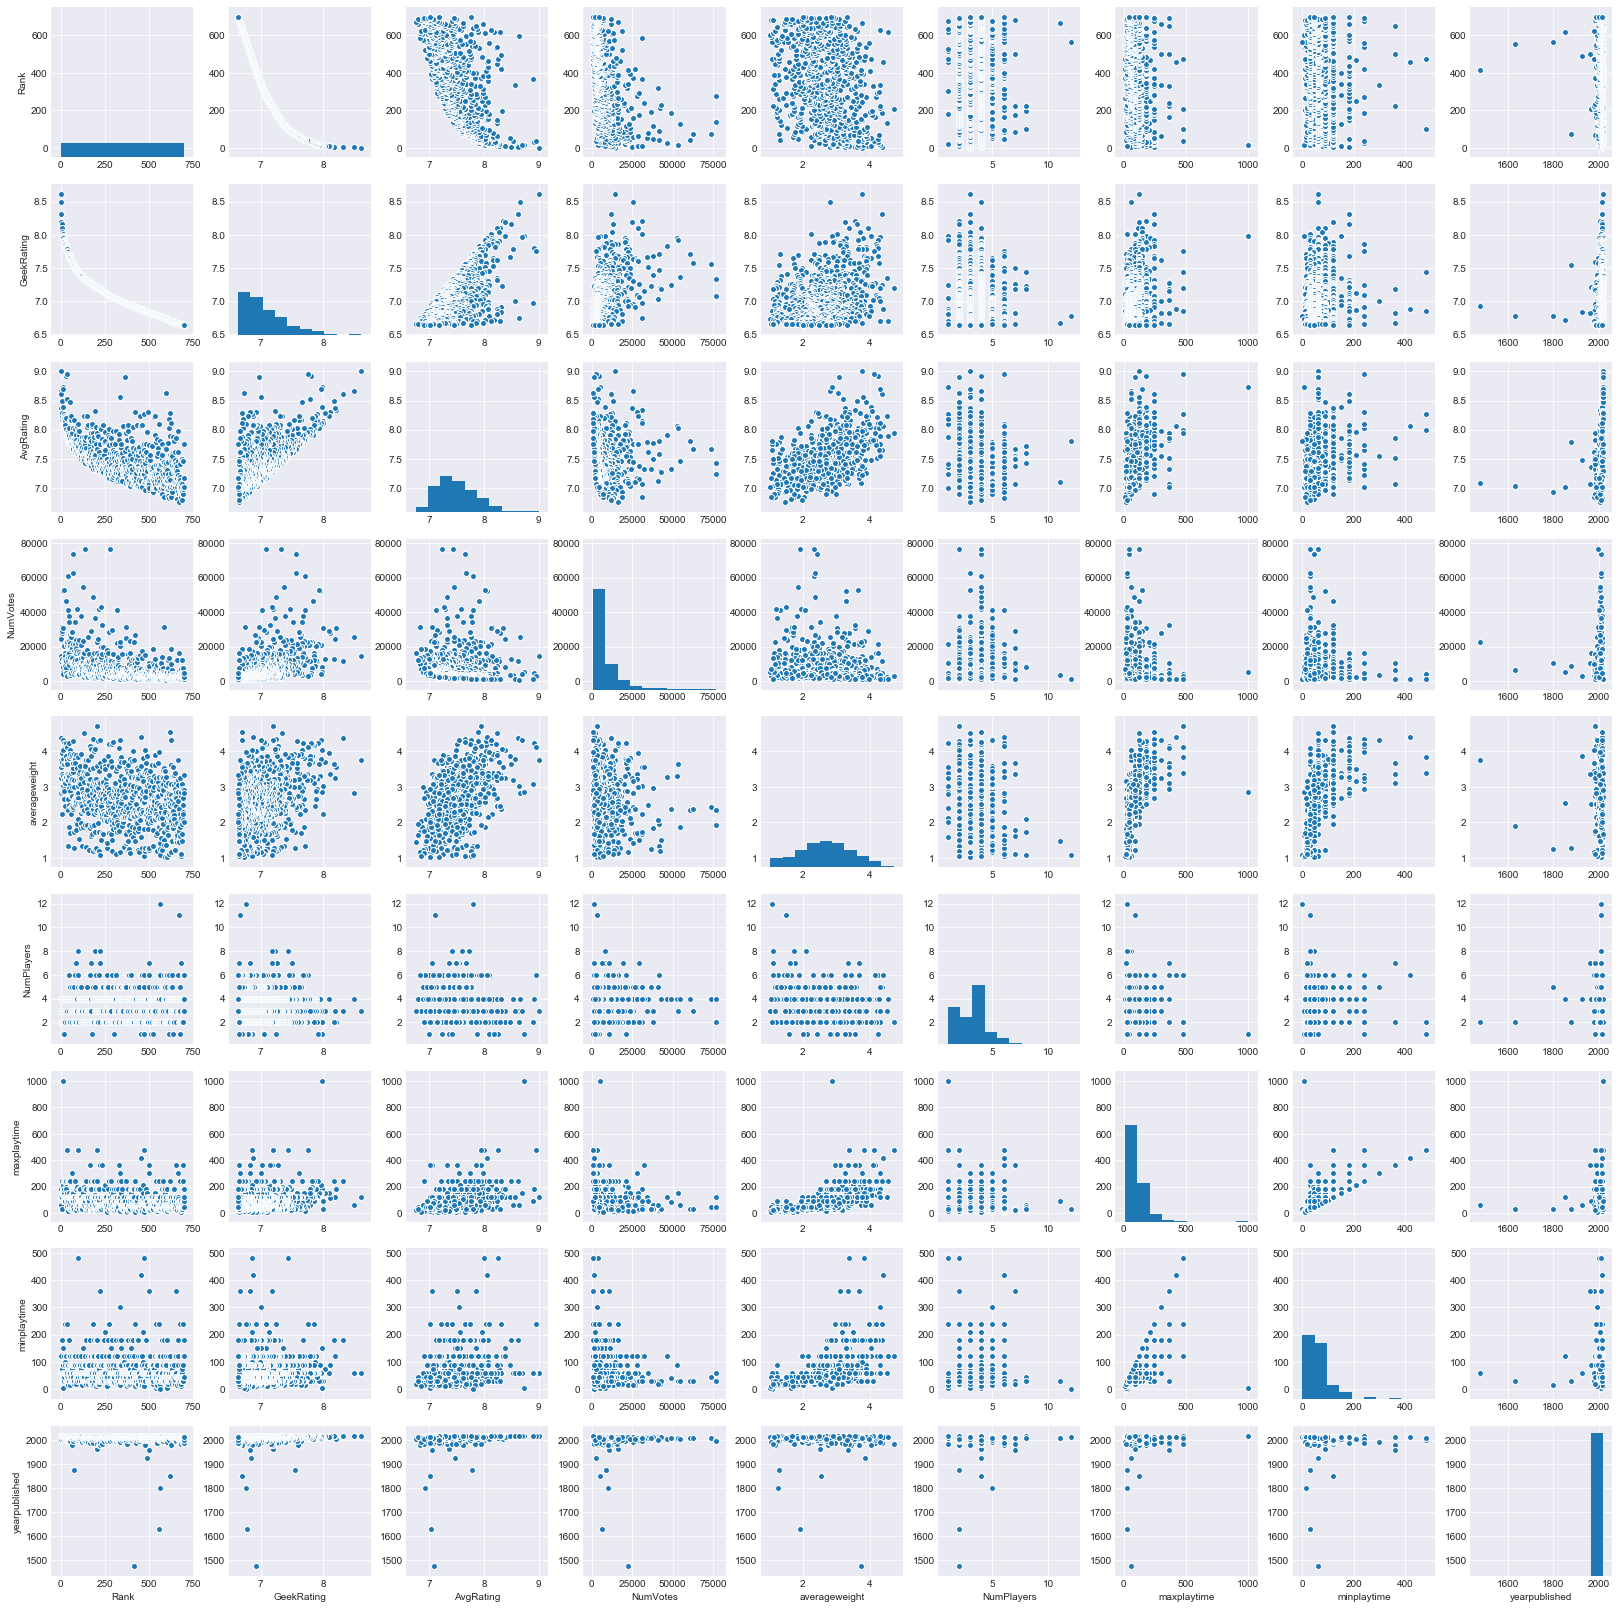

In [265]:
sns.pairplot(modeling_df);

In [275]:
modeling_df.columns

Index(['Rank', 'GeekRating', 'AvgRating', 'NumVotes', 'averageweight',
       'NumPlayers', 'maxplaytime', 'minplaytime', 'yearpublished'],
      dtype='object')

In [306]:
X=modeling_df.loc[:,['GeekRating', 'AvgRating', 'NumVotesLog', 'averageweight',
       'NumPlayers', 'maxplaytime', 'minplaytime', 'yearpublished']]

y=modeling_df['Rank']


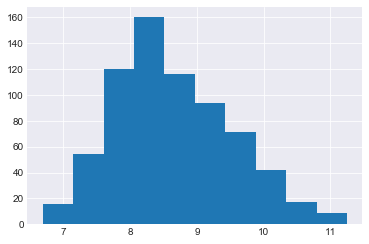

In [337]:
np.log(modeling_df['NumVotes']).hist();

In [305]:
modeling_df['NumVotesLog'] = np.log(modeling_df['NumVotes'])

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [309]:
X_train.columns

Index(['GeekRating', 'AvgRating', 'NumVotesLog', 'averageweight', 'NumPlayers',
       'maxplaytime', 'minplaytime', 'yearpublished'],
      dtype='object')

In [310]:
#Tying out a linear model

from sklearn import datasets, linear_model

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

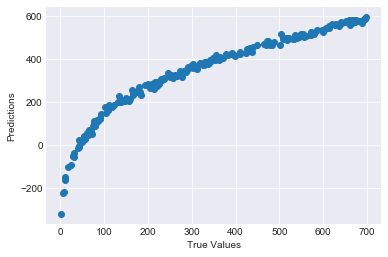

In [326]:
figsize=(12,8)
plt.scatter(y_test, predictions)

plt.xlabel('True Values')
plt.ylabel('Predictions');

In [312]:
model.score(X_test, y_test)

0.89451328944167319

In [322]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy 

y, X = patsy.dmatrices('Rank ~ GeekRating + averageweight + NumVotesLog + NumPlayers + maxplaytime + yearpublished', data=modeling_df, return_type="dataframe")
#y, X = patsy.dmatrices('Rank ~ GeekRating + AvgRating + NumVotes + averageweight + NumPlayers + maxplaytime + minplaytime + yearpublished', data=modeling_df, return_type="dataframe")

# Create your model

model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     856.5
Date:                Mon, 30 Apr 2018   Prob (F-statistic):          2.55e-316
Time:                        05:41:21   Log-Likelihood:                -3957.5
No. Observations:                 699   AIC:                             7929.
Df Residuals:                     692   BIC:                             7961.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4364.1609    194.605     22.426      0.000    3982.074    4746.248
GeekRating     -526.0693     11.553    -45.534      0.000    -548.753    -503.385
averageweight    -7.9982      4.987     -1.604      0.109     -17.790       1.794
NumVotesLog     -14.5314      4.433     -3.278      0.001     -23.236      -5.827
NumPlayers        0.5522      2.136      0.259      0.796      -3.641       4.746
maxplaytime       0.0622      0.044      1.423      0.155      -0.024       0.148
yearpublished    -0.0769      0.096     -0.800      0.424      -0.265       0.112
==============================================================================
Omnibus:                      244.355   Durbin-Watson:                   0.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.881
Skew:                           1.528   Prob(JB):                    1.50e-249
Kurtosis:                       8.477   Cond. No.                     1.48e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

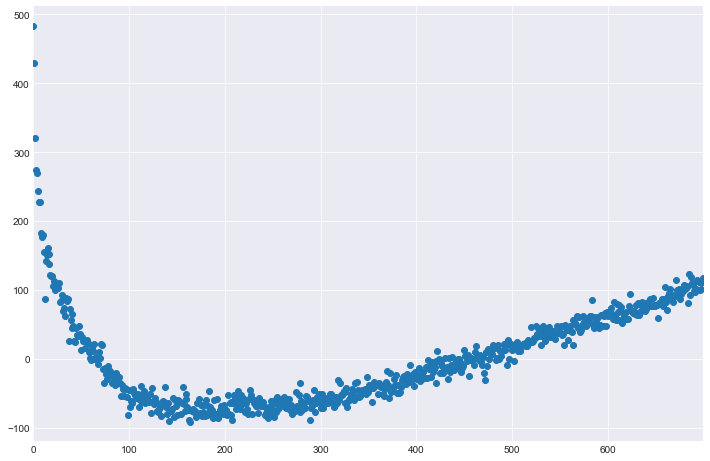

In [323]:
fit.resid.plot(style='o', figsize=(12,8));

In [330]:
lr_model2 = LinearRegression()
lr_model2.fit(X_train,y_train)
lr_model2.coef_

array([ -5.25651014e+02,  -4.51655638e+00,  -1.36893552e+01,
        -6.09771525e+00,  -8.13088115e-01,   1.19548965e-01,
        -1.19940186e-01,  -7.78501776e-02])

In [339]:
lr_model2.fit(X_test,y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [331]:
list(zip(X_train,lr_model2.coef_))

[('GeekRating', -525.651014009807),
 ('AvgRating', -4.5165563790333216),
 ('NumVotesLog', -13.689355192339935),
 ('averageweight', -6.0977152496624525),
 ('NumPlayers', -0.81308811510700107),
 ('maxplaytime', 0.1195489647525021),
 ('minplaytime', -0.11994018577312426),
 ('yearpublished', -0.077850177635174475)]

In [332]:
test_set_pred2 = lr_model2.predict(X_test)

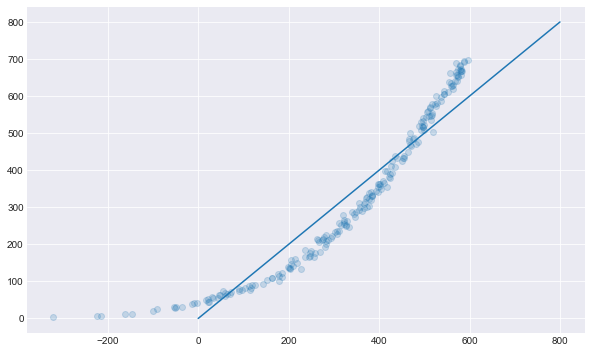

In [336]:
plt.figure(figsize=(10,6))
plt.scatter(test_set_pred2, y_test,alpha=.2)
plt.plot(np.linspace(0,800,800),np.linspace(0,800,800));

In [324]:
# Lasso

from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)

print("r^2 on test data : %f" % r2_score_lasso)


r^2 on test data : 0.894545


ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.825316


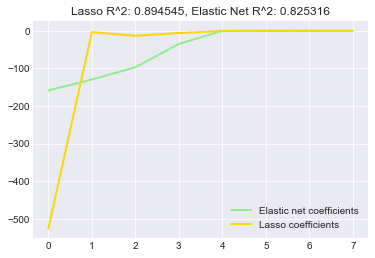

In [325]:
# Trying out elastic net to search for a better coefficient usng the same test-train splits

enet = ElasticNet(alpha=alpha, l1_ratio=0.1)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)

print(enet)
print("r^2 on test data : %f" % r2_score_enet)

plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')


plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

In [338]:
#What happens if we take out the GeekRating out of the model?

import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy 

y3, X3 = patsy.dmatrices('Rank ~ averageweight + NumVotesLog + NumPlayers + maxplaytime + yearpublished', data=modeling_df, return_type="dataframe")
#y, X = patsy.dmatrices('Rank ~ GeekRating + AvgRating + NumVotes + averageweight + NumPlayers + maxplaytime + minplaytime + yearpublished', data=modeling_df, return_type="dataframe")

# Create your model

model3 = sm.OLS(y3, X3)

# Fit your model to your training set
fit3 = model3.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     153.6
Date:                Mon, 30 Apr 2018   Prob (F-statistic):          1.03e-109
Time:                        10:53:41   Log-Likelihood:                -4441.7
No. Observations:                 699   AIC:                             8895.
Df Residuals:                     693   BIC:                             8923.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3855.8716    388.100      9.935      0.000    3093.878    4617.865
averageweight  -101.3225      9.083    -11.156      0.000    -119.155     -83.490
NumVotesLog    -157.1717      6.267    -25.081      0.000    -169.476    -144.868
NumPlayers       12.9778      4.232      3.067      0.002       4.669      21.286
maxplaytime      -0.1130      0.087     -1.299      0.194      -0.284       0.058
yearpublished    -0.9521      0.188     -5.065      0.000      -1.321      -0.583
==============================================================================
Omnibus:                        0.380   Durbin-Watson:                   0.958
Prob(Omnibus):                  0.827   Jarque-Bera (JB):                0.483
Skew:                           0.002   Prob(JB):                        0.786
Kurtosis:                       2.871   Cond. No.                     1.48e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""